<a href="https://colab.research.google.com/github/CA683-Group99/Wind-Energy-Prediction/blob/main/4_IslandElectricityRandomForestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import io
import requests


from plotly.offline import iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from datetime import tzinfo, timedelta, datetime, date

# Any results you write to the current directory are saved as output.

import plotly.express as px
import seaborn as sns

# System Demand and Generation: Actual and Prediction

### Data description
* **System Demand** - represents the predicted electricity production required to meet national consumption.

* **date** - 
* **REGION** - All / Ireland / Nrthern Ireland
* **ActualDemandMW** - Unit MW
* **ForecastDemandMW** - 
* **ForecastWindMW** - 
* **ActualWindMW** - 
* **ActualGenerationMW** - 
* **hour** - 
* **isweekday** - 
* **month** - 
  
Actual and forecast System Demand are shown in **15 minute intervals.**

The data came from EirGrid Group about all island power systems and has been prepared by us for further analysis.

Source: https://smartgriddashboard.eirgrid.com/#all/demand

# Weather Data
 Weather data from weather stations: Belmullet (suffix _BEL), Dublin Airport (_DUB), Shannon Airport (No suffix) and Cork Airport (suffix _COR)

For each station, for example Cork Airport, please see the on https://data.gov.ie/dataset/cork-airport-hourly-data :

Hourly Elements:

| ID | ELEMENT | Unit |
| --- | --- | --- |       
|rain|Precipitation Amount|mm|
|**temp**|Air Temperature|°C|
| wetb|	Wet Bulb Air Temperature|  °C|
|dewpt| Dew Point Air Temperature|	°C	|	
|vappr|	Vapour Pressure	|		hpa|
|rhum	|	Relative Humidity	|	%|
|msl	|	Mean Sea Level Pressure				|		hPa|
|**wdsp**	|	Mean Hourly Wind Speed		|		kt|
|wddir|	Predominant Hourly wind Direction	|	kt|
|ww		Synop Code Present Weather - decode below
|w		Synop Code Past Weather - decode below
|sun		Sunshine duration						hours
|vis		Visibility							m
|clht		Cloud Ceiling Height - if none value is 999			100s feet
|clamt		Cloud Amount							okta

In [74]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
import os
os.chdir('/content/drive/MyDrive/CA683Project')


In [76]:
fileP = 'IslandElectricity2017_2020v3.csv'
newdf = pd.read_csv(fileP, parse_dates=[1], na_values=" ")

In [77]:
#Krystian: Looking for maximal extreme values
print('-----------DATA SIZE -------------')
print(newdf.shape)           # 10 Columns, 35044 rows
count_row = newdf.shape[0]   # 10 Columns
count_col = newdf.shape[1]   # 35044 rows
print('Rows: ', count_row, ', Columns: ', count_col)

print('-----------DATA INFO -------------')
print(newdf.info())

print('-----------DATA MAX Values -------------')
newdf.max()

print('-----------DATA COLUMNS-------------')
columns = newdf.columns.values.tolist()
print (columns)

print('-----------BASIC STATISTICS-------------')
newdf.describe()

-----------DATA SIZE -------------
(36485, 99)
Rows:  36485 , Columns:  99
-----------DATA INFO -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36485 entries, 0 to 36484
Data columns (total 99 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            36485 non-null  int64         
 1   date                  36485 non-null  datetime64[ns]
 2   ind_BEL               36485 non-null  int64         
 3   rain_BEL              36485 non-null  float64       
 4   ind.1_BEL             36485 non-null  int64         
 5   temp_BEL              36485 non-null  float64       
 6   ind.2_BEL             36485 non-null  int64         
 7   wetb_BEL              36485 non-null  float64       
 8   dewpt_BEL             36485 non-null  float64       
 9   vappr_BEL             36485 non-null  float64       
 10  rhum_BEL              36485 non-null  int64         
 11  msl_BEL               

Unnamed: 0  ind_BEL  ...      MOYLE_MW          year
count  36485.000000  36485.0  ...  36466.000000  36484.000000
mean   18242.000000      0.0  ...     47.848324   2018.598016
std    10532.456622      0.0  ...    244.391174      1.197977
min        0.000000      0.0  ...   -408.000000   2017.000000
25%     9121.000000      0.0  ...   -147.000000   2018.000000
50%    18242.000000      0.0  ...    -15.000000   2019.000000
75%    27363.000000      0.0  ...    261.000000   2020.000000
max    36484.000000      0.0  ...    449.000000   2021.000000

[8 rows x 94 columns]

In [78]:
import plotly.express as px

fig = px.scatter(newdf, x='date', y='ActualDemandMW')
fig.show()

In [79]:
eirgridCols = ['ActualDemandMW', 'ActualGenerationMW' , 'ForecastWndMW' , 'ActualWindMW', 'NetTotal_MW' , 'EWIC_MW',  'MOYLE_MW' ]
len(eirgridCols)

7

In [80]:

fig = make_subplots(
    rows=len(eirgridCols), cols=1,
    subplot_titles=(eirgridCols ))
i =1 

fig.print_grid 
for col in eirgridCols:
  missingAW = newdf.loc[newdf[col].isnull() == True]
  #fig = px.scatter(missingAW, x='date', y='hour')
  fig.add_trace(go.Scatter(x=missingAW.date, y=missingAW['hour'], name=(col),  hovertext='label'), i, 1, secondary_y=False)
  i = i+1

fig.update_layout(height=800, width=1200)
fig.show()

In [81]:
fig = go.Figure()
for col in eirgridCols:
  fig.add_trace(go.Box(y=newdf[col], name=col))
fig.show()

Will need to tidy up null values properly!

In [82]:
newdf.loc[newdf['month'].isnull() == True]

Unnamed: 0       date  ind_BEL  ...  EWIC_MW  MOYLE_MW  year
36484       36484 2021-03-01        0  ...      NaN       NaN   NaN

[1 rows x 99 columns]

In [83]:
newdf = newdf.loc[newdf['month'].isnull() == False]

In [84]:
newdf.loc[newdf['ActualWindMW'] < 0]

Unnamed: 0                date  ind_BEL  ...  EWIC_MW  MOYLE_MW    year
4619         4619 2017-07-12 11:00:00        0  ...    -10.0      18.0  2017.0
7332         7332 2017-11-02 11:00:00        0  ...    499.0     421.0  2017.0
7333         7333 2017-11-02 12:00:00        0  ...    515.0     424.0  2017.0
7334         7334 2017-11-02 13:00:00        0  ...    500.0     446.0  2017.0
7335         7335 2017-11-02 14:00:00        0  ...    397.0     406.0  2017.0
7338         7338 2017-11-02 17:00:00        0  ...    285.0     446.0  2017.0
12587       12587 2018-06-09 10:00:00        0  ...     97.0     192.0  2018.0
13950       13950 2018-08-05 05:00:00        0  ...   -273.0     -57.0  2018.0
28814       28814 2020-04-15 11:00:00        0  ...    402.0     446.0  2020.0
31644       31644 2020-08-11 09:00:00        0  ...    163.0     320.0  2020.0
31645       31645 2020-08-11 10:00:00        0  ...    106.0     446.0  2020.0
31646       31646 2020-08-11 11:00:00        0  ...    116.0     446.0  2020.0
31647       31647 2020-08-11 12:00:00        0  ...    197.0     443.0  2020.0
31648       31648 2020-08-11 13:00:00        0  ...    246.0     405.0  2020.0

[14 rows x 99 columns]

In [85]:
fig = px.scatter(newdf, x='hour', y='ActualDemandMW', facet_col='month', color='isweekday')
fig.show()

In [86]:
fig = px.scatter(newdf, x='hour', y='ActualDemandMW', facet_col='year', color='isweekday')
fig.show()

In [87]:
newdf['WindGenPercent'] = (newdf['ActualWindMW'] / newdf['ActualGenerationMW']) * 100
fig = px.scatter(newdf, x='hour', y='WindGenPercent', facet_col='year')
fig.show()

# Prep smaller dataset to run model : reduced dataset for prototype to known important factors

In [88]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36484 entries, 0 to 36483
Data columns (total 100 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            36484 non-null  int64         
 1   date                  36484 non-null  datetime64[ns]
 2   ind_BEL               36484 non-null  int64         
 3   rain_BEL              36484 non-null  float64       
 4   ind.1_BEL             36484 non-null  int64         
 5   temp_BEL              36484 non-null  float64       
 6   ind.2_BEL             36484 non-null  int64         
 7   wetb_BEL              36484 non-null  float64       
 8   dewpt_BEL             36484 non-null  float64       
 9   vappr_BEL             36484 non-null  float64       
 10  rhum_BEL              36484 non-null  int64         
 11  msl_BEL               36484 non-null  float64       
 12  ind.3_BEL             36484 non-null  int64         
 13  wdsp_BEL       

In [89]:
redds = newdf.loc[:, ['date', 'hour', 'isweekday', 'month', 'year', 'wdsp_BEL', 'wddir_BEL', 'temp_BEL']]

In [90]:
redds = newdf.loc[:, ['date', 'hour', 'isweekday', 'month', 'year',
                      'wdsp_BEL', 'wddir_BEL', 'temp_BEL',
                      'wdsp', 'wddir', 'temp',
                      'wdsp_COR', 'wddir_COR',  'temp_COR',
                      'wdsp_DUB', 'wddir_DUB',  'temp_DUB',
                      'msl_BEL', 'msl', 'msl_COR', 'msl_DUB',
                      'ActualWindMW']]

In [91]:
redds[redds.ActualWindMW.isnull() == True]

date  hour isweekday  ...  msl_COR  msl_DUB  ActualWindMW
2017  2017-03-26 01:00:00   1.0     False  ...   1024.9   1028.2           NaN
4153  2017-06-23 01:00:00   1.0      True  ...   1014.5   1011.0           NaN
4154  2017-06-23 02:00:00   2.0      True  ...   1014.0   1010.5           NaN
4155  2017-06-23 03:00:00   3.0      True  ...   1013.7   1010.0           NaN
4156  2017-06-23 04:00:00   4.0      True  ...   1013.8   1009.3           NaN
4157  2017-06-23 05:00:00   5.0      True  ...   1013.5   1009.4           NaN
4158  2017-06-23 06:00:00   6.0      True  ...   1013.8   1009.4           NaN
4159  2017-06-23 07:00:00   7.0      True  ...   1013.8   1009.9           NaN
4160  2017-06-23 08:00:00   8.0      True  ...   1013.7   1010.4           NaN
4161  2017-06-23 09:00:00   9.0      True  ...   1013.4   1010.8           NaN
4162  2017-06-23 10:00:00  10.0      True  ...   1013.7   1011.1           NaN
4163  2017-06-23 11:00:00  11.0      True  ...   1013.9   1011.3           NaN
4164  2017-06-23 12:00:00  12.0      True  ...   1014.2   1010.9           NaN
10754 2018-03-25 01:00:00   1.0     False  ...   1010.5   1009.4           NaN
19659 2019-03-31 01:00:00   1.0     False  ...   1025.4   1027.0           NaN
21277 2019-06-06 11:00:00  11.0      True  ...   1007.8   1006.5           NaN
28396 2020-03-29 01:00:00   1.0     False  ...   1040.9   1044.4           NaN
34495 2020-12-08 03:00:00   3.0      True  ...   1005.3   1001.3           NaN

[18 rows x 22 columns]

## Quite a few missing values in 2017, reducing to 2018 and over

In [92]:
redds = redds.loc[redds['date'] >= "2018-01-01 00:00:00", :]

In [93]:
redds.tail()

date  hour isweekday  ...  msl_COR  msl_DUB  ActualWindMW
36479 2021-02-28 19:00:00  19.0     False  ...   1033.8   1036.0         504.0
36480 2021-02-28 20:00:00  20.0     False  ...   1033.8   1035.9         732.0
36481 2021-02-28 21:00:00  21.0     False  ...   1033.6   1035.8         919.0
36482 2021-02-28 22:00:00  22.0     False  ...   1033.3   1035.5        1024.0
36483 2021-02-28 23:00:00  23.0     False  ...   1033.1   1035.4        1068.0

[5 rows x 22 columns]

Quick backfill (from previous hour value) for the few missing data points 

In [94]:
redds.ActualWindMW.fillna(method='ffill', inplace=True)
redds.fillna(method='ffill', limit=4, inplace=True)

In [95]:
fig = px.scatter(redds, x='date', y='ActualWindMW')
fig.show()

In [96]:
redds.fillna(method='ffill', limit=4, inplace=True)
redds.isweekday = redds.isweekday.astype('bool')

## Correlation matrix and VIF


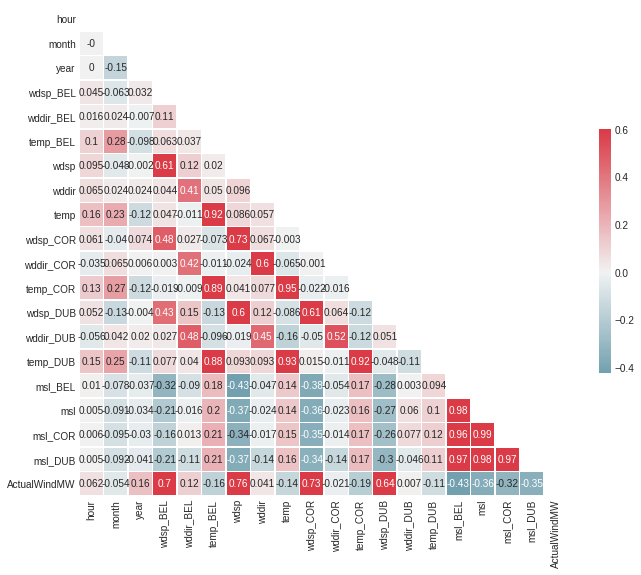

In [97]:
import seaborn as sns

num_df = redds.select_dtypes(['int', 'float'])
# Compute the correlation matrix
corr = num_df.corr()
corr = np.round(corr, 3)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.6, center=0, annot= True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [98]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant

X = redds[['wdsp_BEL', 'wddir_BEL', 'temp_BEL',
                      'wdsp', 'wddir', 'temp',
                      'wdsp_COR', 'wddir_COR',  'temp_COR',
                      'wdsp_DUB', 'wddir_DUB',  'temp_DUB',
           'msl_BEL']]
X = add_constant(X)

vif = [variance_inflation_factor(X.to_numpy(), i) for i in range(X.to_numpy().shape[1])]

print(vif[1:])



[1.772503171273729, 1.4878145942789531, 7.610185972043678, 3.1077971896796175, 1.7630721927768038, 16.36815342858202, 2.5176125420053928, 1.8897826111387015, 12.434417059246435, 1.8531159308053993, 1.6691892130574992, 8.640252262578468, 1.3357468871963134]


In [99]:
pd.DataFrame(X.iloc[:, 1:].columns, vif[1:])

0
1.772503    wdsp_BEL
1.487815   wddir_BEL
7.610186    temp_BEL
3.107797        wdsp
1.763072       wddir
16.368153       temp
2.517613    wdsp_COR
1.889783   wddir_COR
12.434417   temp_COR
1.853116    wdsp_DUB
1.669189   wddir_DUB
8.640252    temp_DUB
1.335747     msl_BEL

 ## Drop temp_COR and Temp as too correlated to Dublin temp and , 'msl', 'msl_COR', 'msl_DUB'


In [100]:
redds.drop(['temp_COR'], axis=1, inplace=True)
redds.drop(['temp'], axis=1, inplace=True)
redds.drop(['msl'], axis=1, inplace=True)
redds.drop(['msl_COR'], axis=1, inplace=True)
redds.drop(['msl_DUB'], axis=1, inplace=True)


# Split data into Training (day of month between 1st and 21st) and Validation (day of the months above 22nd) sets and run Random Forest 

In [101]:
def setdayatt(row):
    row["day"] = row.date.day
    return row

redds["day"] = 0
redds = redds.apply(setdayatt, axis='columns')



In [102]:
from sklearn.model_selection import train_test_split

# Split train vs. Test for day of the month <> 22 to avoid overfitting
X_train_full = redds.loc[(redds.day > 0) & (redds.day < 22), :]
X_valid_full = redds.loc[(redds.day > 22), :]

y_train = X_train_full.ActualWindMW
X_train_full.drop(['ActualWindMW'], axis=1, inplace=True)

y_valid = X_valid_full.ActualWindMW
X_valid_full.drop(['ActualWindMW'], axis=1, inplace=True)

# Break off validation set from training data
#X_train_full, X_valid_full, y_train, y_valid = train_test_split(redds, y, train_size=0.8, test_size=0.2,random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if
                    X_train_full[cname].nunique() < 10 and 
                    X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64', 'bool']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()


In [103]:
y_train.shape , X_train.shape, y_valid.shape, X_valid.shape

((19152,), (19152, 16), (7659,), (7659, 16))

In [104]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define model
model = RandomForestRegressor(n_estimators=100, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))


MAE: 295.8366797232014


In [105]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7659 entries, 9289 to 36483
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       7659 non-null   float64
 1   isweekday  7659 non-null   bool   
 2   month      7659 non-null   float64
 3   year       7659 non-null   float64
 4   wdsp_BEL   7659 non-null   int64  
 5   wddir_BEL  7659 non-null   int64  
 6   temp_BEL   7659 non-null   float64
 7   wdsp       7659 non-null   int64  
 8   wddir      7659 non-null   int64  
 9   wdsp_COR   7659 non-null   int64  
 10  wddir_COR  7659 non-null   int64  
 11  wdsp_DUB   7659 non-null   int64  
 12  wddir_DUB  7659 non-null   float64
 13  temp_DUB   7659 non-null   float64
 14  msl_BEL    7659 non-null   float64
 15  day        7659 non-null   int64  
dtypes: bool(1), float64(7), int64(8)
memory usage: 964.9 KB


In [106]:
# Perform EDA, visualize, etc...
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"secondary_y": True}]],
    subplot_titles=("Wind"))


fig.add_trace(go.Scatter(x=redds['date'], y=redds['ActualWindMW'],
                    mode='lines',
                    name='Wind Actual',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=X_valid_full['date'], y=preds,
                    mode='lines',
                    name='Pred',showlegend=True), 1, 1, secondary_y=False)


fig.update_layout(
    title_text="Wind actual (blue) vs. Predictions (red) for days 22nd and above each month",
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        l=100,
        r=20,
        t=110,
    ),
    plot_bgcolor='white',
    width=4000,
    height=500
)
fig.show()

## Model features importance

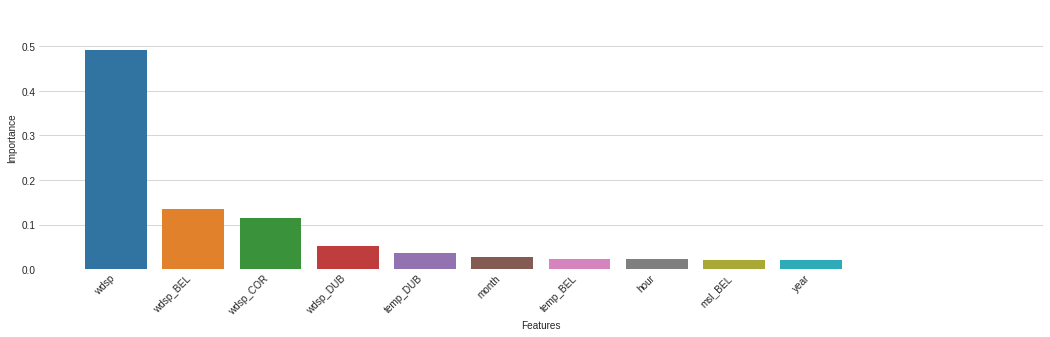

In [107]:
X_cols = X_valid.columns

rfc_fi = pd.DataFrame({'cols':X_cols, 'imp':model.feature_importances_}
                       ).sort_values('imp', ascending=False)

f, ax = plt.subplots(figsize=(18, 5))

chart = sns.barplot(x="cols", y="imp", data=(rfc_fi.loc[rfc_fi.imp > 0.015]))

# Add a legend and informative axis label
ax.set(xlim=(-1, 12), ylabel="Importance",
       xlabel="Features")
sns.despine(left=True, bottom=True)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()

# Met Éireann Weather Forecast API
Published by: Met Éireann
 32 
Licensed under: Met Eireann Custom Open Data Licence
https://data.gov.ie/dataset/met-eireann-weather-forecast-api/resource/027da6d5-d819-48d1-9b16-331dba169bd1

In [108]:

from xml.dom.minidom import parse
import xml.dom.minidom


In [144]:
def getWeather(lat, long, name):

    url = "http://metwdb-openaccess.ichec.ie/metno-wdb2ts/locationforecast?lat={};long={}".format(lat, long)
    s = requests.get(url).content

    DOMTree = xml.dom.minidom.parse(io.StringIO(s.decode('utf-8')))

    collection = DOMTree.documentElement
    if collection.hasAttribute("shelf"):
       print ("Root element : ", collection.getAttribute("shelf"))

    # Get all the movies in the collection
    product = collection.getElementsByTagName("product")

    df_cols = ['date', 'wddir', 'wdsp', 'temp', 'msl']
    rows = []

    product = collection.getElementsByTagName("product")
    timefcs = collection.getElementsByTagName("time")


    # Print detail of each movie.
    for timefc in timefcs:
        if timefc.hasAttribute("from"):
            fromtime =""
            wdeg = None
            wsp = None
            temp = None
            msl = None

            #print ("from: ", timefc.getAttribute("from"))
            fromtime = timefc.getAttribute("from")

            location = timefc.getElementsByTagName('location')[0]

            if (len(location.getElementsByTagName('windDirection')) > 0 ):
                wd = location.getElementsByTagName('windDirection')[0]
                if wd.hasAttribute("deg"):
                    wdeg = float(wd.getAttribute("deg"))
                    #print ("Wi)nd Direction deg: ", wd.getAttribute("deg"))    

            if (len(location.getElementsByTagName('windSpeed')) > 0):
                wsp = location.getElementsByTagName('windSpeed')[0]
                if wsp.hasAttribute("mps"):
                    wsp = float(wsp.getAttribute("mps"))

            if (len(location.getElementsByTagName('temperature')) > 0):
                temp = location.getElementsByTagName('temperature')[0]
                if temp.hasAttribute("value"):
                    temp = float(temp.getAttribute("value"))
  
  
            if (len(location.getElementsByTagName('pressure')) > 0):
                msl = location.getElementsByTagName('pressure')[0]
                if msl.hasAttribute("value"):
                    msl = float(msl.getAttribute("value"))

        # Weather Hourly data wind speed in knt, for some reason, 1 knt = 0.514 m/s
        knot = 0.514
        if (wsp != None):
          wsp = wsp / knot
          
        #print ("From: " + fromtime + " Wind Direction deg: " + str(wdeg) + " Wind Speed mps: " + str(wsp))    
        if (wdeg != None):
            rows.append({"date": fromtime, "wddir": wdeg, "wdsp": wsp, "temp": temp, "msl": msl})



    # <windDirection id="dd" deg="348.0" name="N"/>
    # <windSpeed id="ff" mps="3.2" beaufort="2" name="Svak vind"/>


    out_df = pd.DataFrame(rows, columns = df_cols)
    
    out_df["date"] = pd.to_datetime(out_df["date"], infer_datetime_format=True, errors='ignore')

    out_df.to_csv(name + "weather.csv")

    return out_df

In [145]:
# Belmullet: 54.225, -9.991
lat=54.225
long=-9.991

BELMULLETds = getWeather(lat, long, "Belmullet")

In [146]:
# Cork Airport: 51.8382 Longitude: -8.4880
lat= 51.8382
long= -8.4880

corkairportds = getWeather(lat, long, "Cork")

In [147]:
# Shannon Airport, Ireland. Latitude: 52.7012 Longitude: -8.9215.
lat= 52.7012
long= -8.9215

shannonairportds = getWeather(lat, long, "Shannon")

In [148]:
# Dublin Airport in Ireland. Latitude: 53.4264 Longitude: -6.2499
lat= 53.4264
long= -6.2499

dublinairportds = getWeather(lat, long, "Dublin")

In [149]:
left = BELMULLETds.set_index(['date']).copy()
right = dublinairportds.set_index(['date'])
#right.index = right.index.tz_convert(None)

wfds = left.join(right, lsuffix="_BEL", rsuffix="_DUB")

right = shannonairportds.set_index(['date'])
wfds = wfds.join(right, lsuffix="", rsuffix="_SHA")

right = corkairportds.set_index(['date'])
wfds = wfds.join(right, lsuffix="", rsuffix="_COR")
wfds = wfds.reset_index()


In [150]:
def plotWeatherMeasure(measure='wdsp', label="Wind Speed"):
  # Perform EDA, visualize, etc...
  fig = make_subplots(
      rows=1, cols=1,
      specs=[[{"secondary_y": True}]],
      subplot_titles=("Met Station"))


  fig.add_trace(go.Scatter(x=wfds['date'], y=wfds[measure + '_BEL'],
                      mode='lines',
                      name='Belmullet ' + label,showlegend=True), 1, 1, secondary_y=False)

  fig.add_trace(go.Scatter(x=wfds['date'], y=wfds[measure + '_COR'],
                      mode='lines',
                      name='Cork Airport ' + label,showlegend=True), 1, 1, secondary_y=False)

  fig.add_trace(go.Scatter(x=wfds['date'], y=wfds[measure],
                      mode='lines',
                      name='Shannon Airport ' + label,showlegend=True), 1, 1, secondary_y=False)
  fig.add_trace(go.Scatter(x=wfds['date'], y=wfds[measure + '_DUB'],
                      mode='lines',
                      name='Dublin Airport ' + label, showlegend=True), 1, 1, secondary_y=False)


  fig.update_layout(
      title_text=label,
      xaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          showgrid=False,
          zeroline=False,
          showline=False,
          showticklabels=True,
      ),
      autosize=False,
      margin=dict(
          l=100,
          r=20,
          t=110,
      ),
      plot_bgcolor='white',
      width=1400,
      height=500
  )
  fig.show()  

In [151]:
plotWeatherMeasure(measure='wdsp', label="Wind Speed")

In [152]:
plotWeatherMeasure(measure='msl', label="Air Pressure (hPa)")

In [153]:
fig = go.Figure()
fig.add_trace(go.Box(y=newdf['wdsp_BEL'], name='BEL'))
fig.add_trace(go.Box(y=wfds['wdsp_BEL'], name='BEL forecast'))
fig.add_trace(go.Box(y=newdf['wdsp_DUB'], name = 'DUB'))
fig.add_trace(go.Box(y=wfds['wdsp_DUB'], name='DUB forecast'))
fig.add_trace(go.Box(y=newdf['wdsp'], name = 'SHA'))
fig.add_trace(go.Box(y=wfds['wdsp'], name='SHA forecast'))

fig.add_trace(go.Box(y=newdf['wdsp_COR'], name = 'CORK'))
fig.add_trace(go.Box(y=wfds['wdsp_COR'], name='CORK forecast'))

fig.show()

In [154]:
fig = go.Figure()
fig.add_trace(go.Box(y=newdf['msl'], name='Shannon msl'))
fig.add_trace(go.Box(y=wfds['msl'], name='Shannon Forecast msl'))

fig.add_trace(go.Box(y=newdf['msl_DUB'], name = 'DUB msl'))
fig.add_trace(go.Box(y=wfds['msl_DUB'], name='DUB msl forecast'))
fig.show()

# Run predictions

In [155]:
wfds

date  wddir_BEL   wdsp_BEL  ...   wdsp_COR  temp_COR  msl_COR
0   2021-03-12 17:00:00      228.1  15.758755  ...  21.789883       7.0    995.0
1   2021-03-12 18:00:00      234.9  11.284047  ...  21.984436       6.5    993.4
2   2021-03-12 19:00:00      203.8  13.229572  ...  24.902724       7.1    991.1
3   2021-03-12 20:00:00      264.4  15.953307  ...  19.260700       5.8    990.4
4   2021-03-12 21:00:00      260.6  16.342412  ...  18.482490       4.5    991.0
..                  ...        ...        ...  ...        ...       ...      ...
103 2021-03-21 00:00:00      296.6   7.392996  ...   5.836576       5.1   1032.6
104 2021-03-21 06:00:00      282.7  12.256809  ...   4.863813       2.9   1030.4
105 2021-03-21 12:00:00      283.0  15.369650  ...  10.505837       9.0   1028.0
106 2021-03-21 18:00:00      296.3  13.618677  ...   7.392996       8.6   1024.5
107 2021-03-22 00:00:00      300.0  13.618677  ...   8.365759       7.6   1023.3

[108 rows x 17 columns]

In [156]:
wfds["hour"] = 0
wfds["isweekday"] = False
wfds["month"] = 0
wfds['year'] = 0
wfds["day"] = 0
def settimeattfull(row):
    row["hour"] = row.date.hour
    row["isweekday"] = (row.date.isoweekday() < 6) 
    row["month"] = row.date.month
    row["year"] = row.date.year
    row["day"] = row.date.day
    return row

wfds = wfds.apply(settimeattfull, axis='columns')

In [157]:
wfds.columns

Index(['date', 'wddir_BEL', 'wdsp_BEL', 'temp_BEL', 'msl_BEL', 'wddir_DUB',
       'wdsp_DUB', 'temp_DUB', 'msl_DUB', 'wddir', 'wdsp', 'temp', 'msl',
       'wddir_COR', 'wdsp_COR', 'temp_COR', 'msl_COR', 'hour', 'isweekday',
       'month', 'year', 'day'],
      dtype='object')

In [158]:
redtds = wfds.loc[:, ['hour', 'isweekday', 'month', 'year',
                      'wdsp_BEL', 'wddir_BEL', 'temp_BEL', 
                      'wdsp', 'wddir', 'temp',
                      'wdsp_COR', 'wddir_COR',  'temp_COR',
                      'wdsp_DUB', 'wddir_DUB',  'temp_DUB', 'msl_BEL', 'day']]

In [159]:
redtds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       108 non-null    int64  
 1   isweekday  108 non-null    bool   
 2   month      108 non-null    int64  
 3   year       108 non-null    int64  
 4   wdsp_BEL   108 non-null    float64
 5   wddir_BEL  108 non-null    float64
 6   temp_BEL   108 non-null    float64
 7   wdsp       108 non-null    float64
 8   wddir      108 non-null    float64
 9   temp       108 non-null    float64
 10  wdsp_COR   108 non-null    float64
 11  wddir_COR  108 non-null    float64
 12  temp_COR   108 non-null    float64
 13  wdsp_DUB   108 non-null    float64
 14  wddir_DUB  108 non-null    float64
 15  temp_DUB   108 non-null    float64
 16  msl_BEL    108 non-null    float64
 17  day        108 non-null    int64  
dtypes: bool(1), float64(13), int64(4)
memory usage: 14.6 KB


In [160]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7659 entries, 9289 to 36483
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hour       7659 non-null   float64
 1   isweekday  7659 non-null   bool   
 2   month      7659 non-null   float64
 3   year       7659 non-null   float64
 4   wdsp_BEL   7659 non-null   int64  
 5   wddir_BEL  7659 non-null   int64  
 6   temp_BEL   7659 non-null   float64
 7   wdsp       7659 non-null   int64  
 8   wddir      7659 non-null   int64  
 9   wdsp_COR   7659 non-null   int64  
 10  wddir_COR  7659 non-null   int64  
 11  wdsp_DUB   7659 non-null   int64  
 12  wddir_DUB  7659 non-null   float64
 13  temp_DUB   7659 non-null   float64
 14  msl_BEL    7659 non-null   float64
 15  day        7659 non-null   int64  
dtypes: bool(1), float64(7), int64(8)
memory usage: 964.9 KB


In [161]:

# Preprocessing of validation data, get predictions
preds = clf.predict(redtds)

In [162]:
preds

array([3208.85, 3390.27, 3448.66, 3179.26, 3355.55, 3483.93, 3405.56,
       3270.59, 3282.11, 2723.48, 3145.42, 3224.24, 3064.95, 3038.94,
       2731.39, 2920.27, 3246.78, 3153.6 , 3303.03, 3406.51, 3355.17,
       3334.14, 3383.25, 3411.13, 3302.84, 3409.25, 3372.86, 3326.45,
       3310.11, 3084.04, 3020.25, 3094.62, 2666.52, 2587.43, 2612.76,
       2171.55, 2068.38, 2020.84, 2272.57, 1892.75, 2543.08, 3170.49,
       3264.18, 3298.23, 3041.37, 3361.1 , 3328.67, 3235.1 , 3300.95,
       3017.27, 2964.64, 2556.97, 2439.78, 2177.07, 2015.83, 1740.96,
       1728.27, 1511.49, 1479.34, 1371.41, 1185.51, 1028.11,  919.96,
        662.85,  647.65,  717.58,  686.65,  557.48,  600.29,  585.15,
        430.69,  445.96,  544.65,  583.09,  686.57,  963.41,  948.93,
       1168.1 ,  918.91,  818.12, 1017.59,  956.18,  975.34,  919.7 ,
        697.58,  613.52,  598.84,  738.26,  672.51,  693.76,  811.2 ,
        752.5 ,  413.15,  451.79,  833.84,  824.61,  716.84,  660.41,
        645.79,  828

In [163]:
preds

array([3208.85, 3390.27, 3448.66, 3179.26, 3355.55, 3483.93, 3405.56,
       3270.59, 3282.11, 2723.48, 3145.42, 3224.24, 3064.95, 3038.94,
       2731.39, 2920.27, 3246.78, 3153.6 , 3303.03, 3406.51, 3355.17,
       3334.14, 3383.25, 3411.13, 3302.84, 3409.25, 3372.86, 3326.45,
       3310.11, 3084.04, 3020.25, 3094.62, 2666.52, 2587.43, 2612.76,
       2171.55, 2068.38, 2020.84, 2272.57, 1892.75, 2543.08, 3170.49,
       3264.18, 3298.23, 3041.37, 3361.1 , 3328.67, 3235.1 , 3300.95,
       3017.27, 2964.64, 2556.97, 2439.78, 2177.07, 2015.83, 1740.96,
       1728.27, 1511.49, 1479.34, 1371.41, 1185.51, 1028.11,  919.96,
        662.85,  647.65,  717.58,  686.65,  557.48,  600.29,  585.15,
        430.69,  445.96,  544.65,  583.09,  686.57,  963.41,  948.93,
       1168.1 ,  918.91,  818.12, 1017.59,  956.18,  975.34,  919.7 ,
        697.58,  613.52,  598.84,  738.26,  672.51,  693.76,  811.2 ,
        752.5 ,  413.15,  451.79,  833.84,  824.61,  716.84,  660.41,
        645.79,  828

In [164]:
forecast = wfds.copy()
#forecast['date'] = wfds['date']
forecast['RF_Preds']=preds

forecast.head(24)

date  wddir_BEL   wdsp_BEL  ...  year  day  RF_Preds
0  2021-03-12 17:00:00      228.1  15.758755  ...  2021   12   3208.85
1  2021-03-12 18:00:00      234.9  11.284047  ...  2021   12   3390.27
2  2021-03-12 19:00:00      203.8  13.229572  ...  2021   12   3448.66
3  2021-03-12 20:00:00      264.4  15.953307  ...  2021   12   3179.26
4  2021-03-12 21:00:00      260.6  16.342412  ...  2021   12   3355.55
5  2021-03-12 22:00:00      268.4  14.007782  ...  2021   12   3483.93
6  2021-03-12 23:00:00      296.5  13.618677  ...  2021   12   3405.56
7  2021-03-13 00:00:00      299.8  18.677043  ...  2021   13   3270.59
8  2021-03-13 01:00:00      282.3  19.649805  ...  2021   13   3282.11
9  2021-03-13 02:00:00      280.4  16.536965  ...  2021   13   2723.48
10 2021-03-13 03:00:00      272.8  17.120623  ...  2021   13   3145.42
11 2021-03-13 04:00:00      273.4  15.175097  ...  2021   13   3224.24
12 2021-03-13 05:00:00      291.6  14.007782  ...  2021   13   3064.95
13 2021-03-13 06:00:00      288.5  18.287938  ...  2021   13   3038.94
14 2021-03-13 07:00:00      264.4  18.287938  ...  2021   13   2731.39
15 2021-03-13 08:00:00      282.0  14.007782  ...  2021   13   2920.27
16 2021-03-13 09:00:00      279.2  19.844358  ...  2021   13   3246.78
17 2021-03-13 10:00:00      281.3  20.233463  ...  2021   13   3153.60
18 2021-03-13 11:00:00      275.0  22.957198  ...  2021   13   3303.03
19 2021-03-13 12:00:00      274.9  22.762646  ...  2021   13   3406.51
20 2021-03-13 13:00:00      275.3  23.540856  ...  2021   13   3355.17
21 2021-03-13 14:00:00      274.1  24.708171  ...  2021   13   3334.14
22 2021-03-13 15:00:00      273.7  23.735409  ...  2021   13   3383.25
23 2021-03-13 16:00:00      287.5  23.151751  ...  2021   13   3411.13

[24 rows x 23 columns]

In [165]:
def getCurrentEirgridWindPrediction(): 
  url_base = 'http://smartgriddashboard.eirgrid.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom='
  url_mid = '%2000:00&dateto='
  url_end = '%2023:59'

  now = datetime.now()
  yesterday = now - timedelta(days=1)
  tomorrow = now + timedelta(days=1)

  date_time = yesterday.strftime("%d-%b-%Y")
  tom_date_time = tomorrow.strftime("%d-%b-%Y") 
  #print("Date and Time:",date_time)
  url = url_base + date_time + url_mid + tom_date_time + url_end
  print(url)

  s = requests.get(url).content
  mds = pd.read_csv(io.StringIO(s.decode('utf-8')), na_values='-')
  mds['date'] = pd.to_datetime(mds["DATE & TIME"], infer_datetime_format=True, errors='ignore')
  mds = mds.rename(columns={' FORECAST WIND(MW)' : 'ForecastWndMW'})
  mds = mds.rename(columns={' ACTUAL GENERATION(MW)' : 'ActualGenerationMW'})
  mds.drop('DATE & TIME', axis=1, inplace=True)
  mds.drop(' REGION', axis=1, inplace=True)

  return mds


In [166]:
mds = getCurrentEirgridWindPrediction()
left = forecast.set_index(['date'])
right = mds.set_index(['date'])
forecast = left.join(right)

http://smartgriddashboard.eirgrid.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom=11-Mar-2021%2000:00&dateto=13-Mar-2021%2023:59


In [167]:
# Perform EDA, visualize, etc...
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"secondary_y": True}]],
    subplot_titles=("Met Station"))


fig.add_trace(go.Scatter(x=forecast.index, y=forecast['wdsp_BEL'],
                    mode='lines',
                    name='Belmullet Wind Speed',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=forecast.index, y=preds,
                    mode='lines',
                    name='Wind Preds',showlegend=True), 1, 1, secondary_y=True)

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['ForecastWndMW'],
                    mode='lines',
                    name='Eirgrid Wind Preds',showlegend=True), 1, 1, secondary_y=True)

fig.update_layout(
    title_text="Wind speed ",
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        l=100,
        r=20,
        t=110,
    ),
    plot_bgcolor='white',
    width=1400,
    height=500
)
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=True)
fig.show()

In [168]:
forecast

wddir_BEL   wdsp_BEL  ...  ForecastWndMW    ACTUAL WIND(MW)
date                                       ...                                  
2021-03-12 17:00:00      228.1  15.758755  ...         3714.0                NaN
2021-03-12 18:00:00      234.9  11.284047  ...         3693.0                NaN
2021-03-12 19:00:00      203.8  13.229572  ...         3641.0                NaN
2021-03-12 20:00:00      264.4  15.953307  ...         3579.0                NaN
2021-03-12 21:00:00      260.6  16.342412  ...         3561.0                NaN
...                        ...        ...  ...            ...                ...
2021-03-21 00:00:00      296.6   7.392996  ...            NaN                NaN
2021-03-21 06:00:00      282.7  12.256809  ...            NaN                NaN
2021-03-21 12:00:00      283.0  15.369650  ...            NaN                NaN
2021-03-21 18:00:00      296.3  13.618677  ...            NaN                NaN
2021-03-22 00:00:00      300.0  13.618677  ...            NaN                NaN

[108 rows x 24 columns]

In [169]:
if not os.path.exists('forecast'):
  os.mkdir('forecast')

now = datetime.now()

forecast.to_csv("forecast/RF_forecast" + str(now) + ".csv")